1. Generate random numbers for the Black-Scholes model parameters
2. Calculate call option prices.
3. Buill an ANN on this.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras

from scipy.optimize import minimize

We will focus on call options. The formula is given below:

$c = {S_0}N(d_1) - Ke^{-rT}N(d_2)$</br>
$d_1 = \frac{ \ln{\frac{S_0}{K}} + (r+0.5{\sigma}^2)T}{\sigma\sqrt{T}}$</br>
$d_2 = d_1 - \sigma\sqrt{T} $


S<sub>0</sub> = stock price at time 0</br>
K = strike Price</br>
r = risk free rate of interest</br>
T = time to maturity of the call option</br>
$\sigma$ = volatility of the stock price</br>

N(x) = Cumulative distribution function of a standard normal random variable x

## Random Number Generation of the parameters


In [208]:
m = 20000

S = np.random.uniform(100,150,m)
K = np.random.uniform(0.5*S,1.5*S,m)
r = np.random.uniform(0,0.05,m)
sigma = np.random.uniform(0.1,0.4,m)
T = np.random.uniform(0.25,1,m)

## Calculate Call Option prices using Black Scholes Formula

In [209]:
def get_bs_call(S,K,r,sigma,T):
    
    d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    c = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    return c
    

In [210]:
C = []

for i in range(m):
    
    calls = get_bs_call(S[i],K[i],r[i],sigma[i],T[i])
    C.append(calls)

## Prepare the data to train the ANN

In [211]:
data = {'Spot Price':S,'Strike Price':K,'Risk free rate':r,'Volatility':sigma,'Maturity(yrs)':T,'Call price':C}
rng_df = pd.DataFrame(data)

In [212]:
rng_df.head()

,Spot Price,Strike Price,Risk free rate,Volatility,Maturity(yrs),Call price
0,125.900703,110.150075,0.020227,0.137302,0.362549,16.730432
1,127.899201,181.656098,0.021920,0.181878,0.461025,0.016298
2,144.581775,152.021310,0.008671,0.355548,0.661268,13.910212
3,143.158912,197.724356,0.016423,0.124272,0.599100,0.002428
4,129.308844,126.815162,0.014925,0.306846,0.428436,11.946844


In [213]:
X = rng_df.drop('Call price',axis =1)
y = rng_df['Call price']

In [214]:
# divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=100)

# divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=100)

In [215]:
# Scale features
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

In [216]:
X_train.shape

(11250, 5)

In [217]:
tf.random.set_seed(123)
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)), #the input layer
    keras.layers.Dense(20,activation='sigmoid'), #hidden layer with 20 neurons and sigmoid activation function
    keras.layers.Dense(20,activation='sigmoid'),
    keras.layers.Dense(20,activation='sigmoid'),
    keras.layers.Dense(1,activation='exponential') 
])

model1.compile(optimizer = 'adam',loss = 'mse')
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 5)                 0         
                                                                 
 dense_8 (Dense)             (None, 20)                120       
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [219]:
history1 = model1.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val))

Epoch 1/100
352/352 [==============================] - 2s 5ms/step - loss: 12.3859 - val_loss: 11.1431
Epoch 2/100
352/352 [==============================] - 2s 5ms/step - loss: 11.8919 - val_loss: 10.2353
Epoch 3/100
352/352 [==============================] - 2s 5ms/step - loss: 9.9589 - val_loss: 10.5063
Epoch 4/100
352/352 [==============================] - 2s 6ms/step - loss: 8.6273 - val_loss: 7.9363
Epoch 5/100
352/352 [==============================] - 2s 5ms/step - loss: 7.4248 - val_loss: 6.8351
Epoch 6/100
352/352 [==============================] - 2s 5ms/step - loss: 6.1818 - val_loss: 6.1978
Epoch 7/100
352/352 [==============================] - 2s 5ms/step - loss: 5.4049 - val_loss: 4.5429
Epoch 8/100
352/352 [==============================] - 2s 6ms/step - loss: 4.6415 - val_loss: 4.6807
Epoch 9/100
352/352 [==============================] - 2s 5ms/step - loss: 4.4444 - val_loss: 4.2157
Epoch 10/100
352/352 [==============================] - 2s 6ms/step - loss: 3.9378 - v

352/352 [==============================] - 2s 5ms/step - loss: 1.0656 - val_loss: 1.3639
Epoch 82/100
352/352 [==============================] - 2s 5ms/step - loss: 1.0956 - val_loss: 1.0383
Epoch 83/100
352/352 [==============================] - 2s 5ms/step - loss: 1.1797 - val_loss: 1.0557
Epoch 84/100
352/352 [==============================] - 2s 5ms/step - loss: 1.0787 - val_loss: 0.9429
Epoch 85/100
352/352 [==============================] - 2s 5ms/step - loss: 1.0832 - val_loss: 1.2635
Epoch 86/100
352/352 [==============================] - 2s 5ms/step - loss: 1.0861 - val_loss: 1.1320
Epoch 87/100
352/352 [==============================] - 2s 5ms/step - loss: 0.9456 - val_loss: 0.8730
Epoch 88/100
352/352 [==============================] - 2s 5ms/step - loss: 1.0100 - val_loss: 1.0030
Epoch 89/100
352/352 [==============================] - 2s 5ms/step - loss: 1.0449 - val_loss: 0.9849
Epoch 90/100
352/352 [==============================] - 2s 5ms/step - loss: 1.0930 - val_loss: 

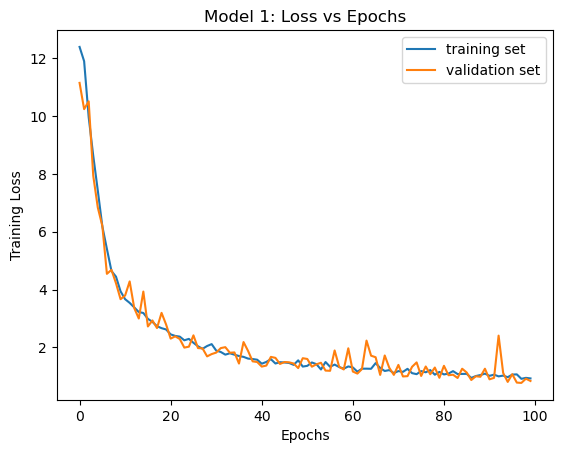

In [220]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Model 1: Loss vs Epochs")
plt.legend(['training set','validation set'])
plt.show()

In [221]:
model1.evaluate(X_test,y_test)

157/157 [==============================] - 1s 3ms/step - loss: 0.7619


0.7619492411613464

**It appears that the machine has fit the model quite well!**

In [222]:
preds1 = model1.predict(X_test)

157/157 [==============================] - 0s 2ms/step


In [223]:
print(len(preds1))

count = 0

for i in range(5000):
    
    if preds1[i]<0:
        count+=1
print(count)

5000
0


In [224]:
mse = np.mean((preds1-y_test)**2)
mse

740.5535021653337

In [225]:
rmse = np.sqrt(mse)
rmse

27.213112687918187

In [226]:
test_val = np.array([[ df.iloc[0,0],df.iloc[0,1],df.iloc[0,2],df.iloc[0,3],df.iloc[0,4] ]])
print(get_bs_call(df.iloc[0,0],df.iloc[0,1],df.iloc[0,2],df.iloc[0,3],df.iloc[0,4]))
model1.predict(test_val)

9.772796023325398
1/1 [==============================] - 0s 49ms/step


array([[10.387599]], dtype=float32)

In [227]:
tv = np.array([[ X_test.iloc[0,0], X_test.iloc[0,1], X_test.iloc[0,2], X_test.iloc[0,3], X_test.iloc[0,4] ]])
print(model1.predict(tv))
print(get_bs_call(X_test.iloc[0,0], X_test.iloc[0,1], X_test.iloc[0,2], X_test.iloc[0,3], X_test.iloc[0,4]))

1/1 [==============================] - 0s 15ms/step
[[45.23338]]
44.83247432558551


## Working with real world market data

In [228]:
#load market data

market_df = pd.read_csv("OTM_Calls.csv")
market_df.head()

,Unnamed: 0,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Expiration,Spot Price
0,107,SPXW230714C04400000,2023-07-10 1:45PM EDT,4400.0,29.70,29.5,29.7,-0.80,-2.62%,1469,3110,12.99%,0.015873,4398.950195
1,108,SPXW230714C04405000,2023-07-10 1:35PM EDT,4405.0,26.50,26.5,26.8,-1.60,-5.69%,456,321,12.84%,0.015873,4398.950195
2,109,SPXW230714C04410000,2023-07-10 1:44PM EDT,4410.0,23.80,23.7,23.9,-1.20,-4.80%,1118,441,12.61%,0.015873,4398.950195
3,110,SPXW230714C04415000,2023-07-10 1:30PM EDT,4415.0,21.70,21.7,21.9,-1.05,-4.62%,260,1087,12.75%,0.015873,4398.950195
4,111,SPXW230714C04420000,2023-07-10 1:41PM EDT,4420.0,18.72,19.0,19.2,-1.64,-8.06%,496,747,12.47%,0.015873,4398.950195


In [229]:
print(market_df['Contract Name'].str.contains('SPXW').sum())
print(len(market_df))

224
817


We remove the weekly options contracts!

In [230]:
market_df = market_df[~market_df['Contract Name'].str.contains('SPXW')]

In [231]:
len(market_df)

593

In [232]:
m_df = market_df[['Spot Price','Strike', 'Expiration','Last Price']]
m_df.head()

,Spot Price,Strike,Expiration,Last Price
63,4398.950195,4405.0,0.154762,83.64
64,4398.950195,4410.0,0.154762,76.45
65,4398.950195,4415.0,0.154762,77.35
66,4398.950195,4420.0,0.154762,73.39
67,4398.950195,4425.0,0.154762,71.34


In [233]:
m_df['Interest Rate'] = 0.0525

/var/folders/lw/7zkwp1j916l4xty0z4xy6mgh0000gn/T/ipykernel_20884/3197249160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_df['Interest Rate'] = 0.0525


In [234]:
m_df.head()

,Spot Price,Strike,Expiration,Last Price,Interest Rate
63,4398.950195,4405.0,0.154762,83.64,0.0525
64,4398.950195,4410.0,0.154762,76.45,0.0525
65,4398.950195,4415.0,0.154762,77.35,0.0525
66,4398.950195,4420.0,0.154762,73.39,0.0525
67,4398.950195,4425.0,0.154762,71.34,0.0525


In [235]:
m_df = m_df[['Spot Price','Strike','Interest Rate','Expiration','Last Price']]
m_df.head()

,Spot Price,Strike,Interest Rate,Expiration,Last Price
63,4398.950195,4405.0,0.0525,0.154762,83.64
64,4398.950195,4410.0,0.0525,0.154762,76.45
65,4398.950195,4415.0,0.0525,0.154762,77.35
66,4398.950195,4420.0,0.0525,0.154762,73.39
67,4398.950195,4425.0,0.0525,0.154762,71.34


## Find Implied Volatility of Market Data
using Black Scholed formula

In [236]:
def get_implied_volatility(S, K, r, T, market_price, tolerance=1e-1, max_iterations=100):
    
    
    #values = []
    
    #set iv bounds
    iv_low = 0.05
    iv_high = 0.99

    for i in range(max_iterations):
        
        iv_mid = (iv_low+iv_high)/2
        
        cal_price = get_bs_call(S,K,r,iv_mid,T)
        
        #print(cal_price,type(cal_price)) #prints a series, but why??? It shouldn't!
        
        if abs(market_price-cal_price)<tolerance:
            return iv_mid
    
        if cal_price<market_price:
            iv_low = iv_mid
        else:
            iv_high = iv_mid
            
        #values.append((market_price,cal_price))
            
    return -1

In [237]:
bs_ivs = []

for i in range(len(m_df)):
    
    S = m_df.iloc[i,0]
    K = m_df.iloc[i,1]
    r = m_df.iloc[i,2]
    T = m_df.iloc[i,3]
    a = m_df.iloc[i,4]
    #print(a,type(a))
    
    ivs = get_implied_volatility(S,K,r,T,a)
    bs_ivs.append(ivs)

In [238]:
# bs_ivs

In [239]:
count = 0

for i in bs_ivs:
    if i==-1:
        count+=1
print(count,len(bs_ivs))

0 593


## Find Implied Volatility of Market Data
using ANN

In [240]:
m_df['IV_BS'] = bs_ivs
m_df.head()

,Spot Price,Strike,Interest Rate,Expiration,Last Price,IV_BS
63,4398.950195,4405.0,0.0525,0.154762,83.64,0.098652
64,4398.950195,4410.0,0.0525,0.154762,76.45,0.091997
65,4398.950195,4415.0,0.0525,0.154762,77.35,0.097275
66,4398.950195,4420.0,0.0525,0.154762,73.39,0.095439
67,4398.950195,4425.0,0.0525,0.154762,71.34,0.096357


In [147]:
test_value = np.array([ [m_df.iloc[10,0], m_df.iloc[10,1], m_df.iloc[10,2], m_df.iloc[10,5], m_df.iloc[10,3] ]])
#cp_pred = model1.predict(test_value)

In [148]:
test_value

array([[4.39895020e+03, 4.51000000e+03, 5.25000000e-02, 8.66308594e-02,
        1.54761905e-01]])

In [149]:
model1.predict(test_value)

1/1 [==============================] - 0s 18ms/step


array([[20.906052]], dtype=float32)

In [241]:
ann_ivs = []

for i in range(len(m_df)):

    
    test_value = np.array([[ m_df.iloc[i,0], m_df.iloc[i,1], m_df.iloc[i,2], m_df.iloc[i,5], m_df.iloc[i,3] ]])
    
    cp_pred = model1.predict(test_value)#predicted price
    
    iv = get_implied_volatility(m_df.iloc[i,0],m_df.iloc[i,1], m_df.iloc[i,2], m_df.iloc[i,5], cp_pred)
    
    ann_ivs.append(iv)

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


In [242]:
m_df['IV_ANN'] = ann_ivs
m_df.head()

,Spot Price,Strike,Interest Rate,Expiration,Last Price,IV_BS,IV_ANN
63,4398.950195,4405.0,0.0525,0.154762,83.64,0.098652,0.063999
64,4398.950195,4410.0,0.0525,0.154762,76.45,0.091997,0.073179
65,4398.950195,4415.0,0.0525,0.154762,77.35,0.097275,0.074785
66,4398.950195,4420.0,0.0525,0.154762,73.39,0.095439,0.080752
67,4398.950195,4425.0,0.0525,0.154762,71.34,0.096357,0.084424


In [244]:
tol = 1e-1
count = (abs(m_df['IV_BS']-m_df['IV_ANN'])<tol).sum()

In [247]:
count/len(m_df)

0.44350758853288363

# BREAK!!!
The code below is a work in progress!

In [54]:
def error_function(m_df,sigma):
    
    
    data = {'Sigmas': [sigma] * len(m_df)}
    df1 = pd.DataFrame(data)
    
    df2 = pd.concat([df1, m_df], axis=1)
    
    xtest = df2.drop('Last Price',axis = 1)
    xtest = np.asarray(xtest).astype('float32')
    ytest = df2['Last Price']
    
    #ytest = np.asarray(ytest)
    #print(xtest.shape)
    preds = model1.predict(xtest)
    
    errors = (preds.flatten() - ytest.values)**2
    
    return np.mean(errors)    
    
    

In [51]:
error = error_function(m_df,sigma)

(817, 5)
26/26 [==============================] - 0s 2ms/step


In [52]:
error

8961.437737670138

In [55]:
min_sigma = 0.2
max_sigma = 0.6
step_size = 0.01

best_sigma = None
best_error = np.inf

for sigma in np.arange(min_sigma, max_sigma + step_size, step_size):
    error = error_function(m_df,sigma)
    if error < best_error:
        print(error,sigma)
        best_error = error
        best_sigma = sigma

print("Optimal Parameter Value:", best_sigma)

26/26 [==============================] - 0s 2ms/step
8961.437737670138 0.2
26/26 [==============================] - 0s 2ms/step
Optimal Parameter Value: 0.2


In [ ]:
X_train.shape

In [ ]:
# sigma = 5
# m_df = m_df.assign(Sigmas=sigma)
# m_df.head()
# m_df = m_df.drop('Sigmas',axis=1)
# # xtest = m_df.drop('Last Price',axis = 1)
# # xtest.head()

In [ ]:
# def myfun2(m_df,sigma):
    
#     for i in range(len(m_df)):
        
#         m_df.loc[i,'Sigmas'] = sigma
#         xtest = m_df.drop('Last Price',axis = 1)
#         ytest = 
        

In [ ]:
initial_sigma = 0.23
result = minimize(lambda sigma: np.sum(error_function(m_df,sigma) ** 2), initial_sigma, options={'maxiter': 10000})
result.x

In [31]:
def get_vega(S,K,mu,sigma,T):
    
    d1 = (np.log(S/K) + (mu + 0.5*sigma**2)*T)/(sigma*T)
    v = S*np.sqrt(T)*norm.cdf(d1)
    return v

In [32]:
def find_implied_volatility(S, K, r, T, option_price, tolerance, max_iterations):
    volatility = 0.5  # Initial guess for implied volatility

    for _ in range(max_iterations):
        option_price_estimate = get_bs_call(S, K, r,volatility, T)
        vega = get_vega(S, K, r, volatility, T)

        diff = option_price_estimate - option_price

        if abs(diff) < tolerance:
            return volatility

        volatility -= diff / vega
    
    return -1

In [ ]:
m_df

In [33]:
ivs = []

for i in range(len(m_df)):
    
    S = m_df.iloc[i,0]
    K = m_df.iloc[i,1]
    r = m_df.iloc[i,4]
    T = m_df.iloc[1,2]
    option_price = m_df.iloc[i,3]
    
    a = find_implied_volatility(S,K,r,T,option_price,tolerance=1e-2, max_iterations=350)
    ivs.append(a)

/var/folders/lw/7zkwp1j916l4xty0z4xy6mgh0000gn/T/ipykernel_20884/3404009167.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  volatility -= diff / vega
/var/folders/lw/7zkwp1j916l4xty0z4xy6mgh0000gn/T/ipykernel_20884/2398144966.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
/var/folders/lw/7zkwp1j916l4xty0z4xy6mgh0000gn/T/ipykernel_20884/2398144966.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))


In [34]:
count = 0
for i in ivs:
    if i==-1:
        count+=1
print(count,len(ivs))


401 593


In [ ]:


# Objective Function
def objective_function(parameter):
    # Calculate the squared sum of differences between experimental and theoretical values
    theoretical_values = theoretical_calculation(parameter)
    differences = experimental_values - theoretical_values
    squared_sum = np.sum(differences ** 2)
    return squared_sum

# Grid Search for Parameter Calibration
min_parameter = 0.0
max_parameter = 5.0
step_size = 0.1

best_parameter = None
best_error = np.inf

for parameter in np.arange(min_parameter, max_parameter + step_size, step_size):
    error = objective_function(parameter)
    if error < best_error:
        best_error = error
        best_parameter = parameter

print("Optimal Parameter Value:", best_parameter)